# Gradient-Boosted Decision Trees (GBDTs)

## 1. Loading the data

In [44]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load actual generation data
df_observed = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Load generation forecasts
df_forecasts = pd.read_csv(
    os.path.join(data_dir, "neso_forecasts.csv"),
    parse_dates=["TARGET_DATE", "ISSUE_DATE"],
)

# Load gas prices
df_gas_price = pd.read_csv(
    os.path.join(data_dir, "gas_prices.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

if df_observed.isna().values.any():
    print("Warning: BMRS dataset contains null values.")

if df_forecasts.isna().values.any():
    print("Warning: NESO dataset contains null values.")

if df_gas_price.isna().values.any():
    print("Warning: Gas price dataset contains null values.")

Convert settlement dates and periods to timestamps:

In [45]:
from utilities.datatools import create_timestamps

df_observed["TIMESTAMP"] = create_timestamps(
    df_observed,
    date_column="SETTLEMENT_DATE",
    period_column="SETTLEMENT_PERIOD",
    tz="UTC"
)
df_observed = df_observed.drop(columns=["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"])

df_forecasts["TIMESTAMP"] = create_timestamps(
    df_forecasts,
    date_column="TARGET_DATE",
    period_column="TARGET_PERIOD",
    tz="UTC",
)
df_forecasts = df_forecasts.drop(columns=["TARGET_DATE", "TARGET_PERIOD"])

df_gas_price["TIMESTAMP"] = df_gas_price["SETTLEMENT_DATE"].dt.tz_localize("UTC")
df_gas_price = df_gas_price.drop(columns=["SETTLEMENT_DATE"])

Merge gas prices with training data:

In [46]:
df_train = df_observed.merge(df_gas_price, on="TIMESTAMP", how="left")
df_train["NATURAL_GAS_PRICE"] = df_train["NATURAL_GAS_PRICE"].ffill()
df_train = df_train.rename(columns={"INDO": "DEMAND"})

df_train = df_train.set_index("TIMESTAMP")
df_train.index = df_train.index.round('30min')
df_train = df_train.asfreq('30min')

if df_train.index.duplicated().any():
    print("WARNING: Found duplicate indices")

if df_train.isna().values.any():
    print("WARNING: Found null values")

df_train.head()

,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,DEMAND,ITSO,ELECTRICITY_PRICE,TRADING_VOLUME,NATURAL_GAS_PRICE
TIMESTAMP,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3116.0,11268.0,0.0,0.0,5949.0,0.0,4734.688,576.0,3428.0,28263.0,28880.0,68.54,407.30,19.499
2021-01-01 00:30:00+00:00,3118.0,11526.0,0.0,0.0,5956.0,1.0,4524.192,569.0,3572.0,28403.0,29018.0,69.82,601.40,19.499
2021-01-01 01:00:00+00:00,3087.0,11240.0,0.0,0.0,5948.0,1.0,4423.037,535.0,3570.0,27633.0,28252.0,67.42,608.00,19.499
2021-01-01 01:30:00+00:00,3117.0,10365.0,0.0,0.0,5950.0,0.0,4309.821,521.0,3568.0,26768.0,27625.0,65.45,579.35,19.499
2021-01-01 02:00:00+00:00,3113.0,10020.0,0.0,0.0,5949.0,0.0,4306.346,517.0,3512.0,25876.0,27051.0,59.44,729.40,19.499


In [47]:
# Locate null values
nan_rows = df_train[df_train.isna().any(axis=1)]

print(f'NUMBER OF NULL ROWS: {len(nan_rows)} out of {len(df_train)}')

print("HEAD OF NULL ROWS:")
print(nan_rows.head().to_string())
print("\nTAIL OF NULL ROWS:")
print(nan_rows.tail().to_string())

NUMBER OF NULL ROWS: 1920 out of 70128
HEAD OF NULL ROWS:
                           BIOMASS  GAS  COAL  OIL  NUCLEAR  SOLAR  WIND  OTHER  INTER  DEMAND  ITSO  ELECTRICITY_PRICE  TRADING_VOLUME  NATURAL_GAS_PRICE
TIMESTAMP                                                                                                                                                 
2021-02-16 00:00:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 00:30:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 01:00:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 01:30:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 0

Shift natural gas price back by two days for use in day-ahead forecasts:

In [48]:
df_gas_price_forecast = df_gas_price.copy()
df_gas_price["NATURAL_GAS_PRICE"] = df_gas_price["NATURAL_GAS_PRICE"].shift(2)
df_test = df_forecasts.merge(df_gas_price, on="TIMESTAMP", how="left")
df_test["NATURAL_GAS_PRICE"] = df_test["NATURAL_GAS_PRICE"].ffill()

df_test = df_test.set_index("TIMESTAMP")
df_test.index = df_test.index.round('30min')
df_test = df_test.asfreq('30min')

if df_test.index.duplicated().any():
    print("WARNING: Found duplicate indices")

if df_test.isna().values.any():
    print("WARNING: Found null values")

df_test.head()

,ISSUE_DATE,DEMAND_FORECAST,WIND_FORECAST,WIND_CAPACITY,EMBEDDED_WIND_FORECAST,EMBEDDED_SOLAR_FORECAST,ISSUE_PERIOD,NATURAL_GAS_PRICE
TIMESTAMP,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-01,26217.740741,2383.0,15729.0,879.0,0.0,18.0,NaN
2021-01-02 00:30:00+00:00,2021-01-01,26622.000000,2382.0,15729.0,867.0,0.0,18.0,NaN
2021-01-02 01:00:00+00:00,2021-01-01,26829.592593,2398.0,15729.0,867.0,0.0,18.0,NaN
2021-01-02 01:30:00+00:00,2021-01-01,26906.074074,2429.0,15729.0,863.0,0.0,18.0,NaN
2021-01-02 02:00:00+00:00,2021-01-01,26917.000000,2474.0,15729.0,863.0,0.0,18.0,NaN


In [49]:
# Locate null values
nan_rows = df_test[df_test.isna().any(axis=1)]

print(f'NUMBER OF NULL ROWS: {len(nan_rows)} out of {len(df_test)}')

print("HEAD OF NULL ROWS:")
print(nan_rows.head().to_string())
print("\nTAIL OF NULL ROWS:")
print(nan_rows.tail().to_string())

NUMBER OF NULL ROWS: 6288 out of 70080
HEAD OF NULL ROWS:
                          ISSUE_DATE  DEMAND_FORECAST  WIND_FORECAST  WIND_CAPACITY  EMBEDDED_WIND_FORECAST  EMBEDDED_SOLAR_FORECAST  ISSUE_PERIOD  NATURAL_GAS_PRICE
TIMESTAMP                                                                                                                                                            
2021-01-02 00:00:00+00:00 2021-01-01     26217.740741         2383.0        15729.0                   879.0                      0.0          18.0                NaN
2021-01-02 00:30:00+00:00 2021-01-01     26622.000000         2382.0        15729.0                   867.0                      0.0          18.0                NaN
2021-01-02 01:00:00+00:00 2021-01-01     26829.592593         2398.0        15729.0                   867.0                      0.0          18.0                NaN
2021-01-02 01:30:00+00:00 2021-01-01     26906.074074         2429.0        15729.0                   863.0     

## 2. Feature engineering

In [50]:
# Keep only desired columns and standardise names
df_train = df_train[
    ["ELECTRICITY_PRICE", "WIND", "SOLAR", "DEMAND", "NATURAL_GAS_PRICE"]
]

df_test = df_test[
    ["WIND_FORECAST", "EMBEDDED_SOLAR_FORECAST",
    "DEMAND_FORECAST", "NATURAL_GAS_PRICE"]
]

df_test = df_test.rename(columns={
    "WIND_FORECAST": "WIND",
    "EMBEDDED_SOLAR_FORECAST": "SOLAR",
    "DEMAND_FORECAST": "DEMAND"
})

In [51]:
import holidays

def create_temporal_features(df: pd.DataFrame, local_time_col: str) -> pd.DataFrame:
    local_timestamps = df[local_time_col]

    hour = local_timestamps.dt.hour
    df["hour_sin"] = np.sin(4 * np.pi * (hour - 1) / 24)
    df["hour_cos"] = np.cos(4 * np.pi * (hour - 1) / 24)

    dow = local_timestamps.dt.dayofweek
    df["dayofweek_sin"] = np.sin(2 * np.pi * dow / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * dow / 7)
    df["is_weekend"] = dow.isin([5, 6])

    gb_holidays = holidays.country_holidays(country="GB")
    dates = local_timestamps.dt.date
    check_holidays = np.vectorize(lambda date_: date_ in gb_holidays)
    df["is_holiday"] = check_holidays(dates).astype(int)

    month = local_timestamps.dt.month
    df["month_sin"] = np.sin(2 * np.pi * (month - 1) / 12)
    df["month_cos"] = np.cos(2 * np.pi * (month - 1) / 12)

    return df

In [52]:
df_train["LOCAL_TIME"] = df_train.index.tz_convert('Europe/London')
df_train = create_temporal_features(df_train, "LOCAL_TIME")
df_train = df_train.drop(columns=["LOCAL_TIME"])

df_test["LOCAL_TIME"] = df_test.index.tz_convert('Europe/London')
df_test = create_temporal_features(df_test, "LOCAL_TIME")
df_test = df_test.drop(columns=["LOCAL_TIME"])

## 3. Make a point forecast

Train-test split:

In [53]:
import datetime

train_dates = pd.date_range(
    start=datetime.date(year=2024, month=11, day=1),
    end=datetime.date(year=2024, month=11, day=14),
    tz="UTC",
    freq='30min',
    normalize=True,
    inclusive="left"
)

test_dates = pd.date_range(
    start=datetime.date(year=2024, month=11, day=14),
    end=datetime.date(year=2024, month=11, day=15),
    tz="UTC",
    freq='30min',
    normalize=True,
    inclusive="left"
)

# Endogenous variable
endog_train = df_train.loc[train_dates, "ELECTRICITY_PRICE"]
endog_test = df_train.loc[test_dates, "ELECTRICITY_PRICE"]

# Exogenous variables
exog_train = df_train.loc[train_dates].drop(columns=["ELECTRICITY_PRICE"])
exog_test = df_test.loc[test_dates]

Specify and train model:

In [54]:
import statsmodels.api as sm
from sklearn.ensemble import HistGradientBoostingRegressor

# Stage 1: Fit GBDTs on exogenous variables
gbdt = HistGradientBoostingRegressor()
gbdt.fit(exog_train, endog_train)

# Stage 2: Fit ARIMA on GBDT residuals
gbdt_residuals = endog_train - gbdt.predict(exog_train)

order = (1, 0, 1)
seasonal_order = (1, 0, 1, 48)

arima_model = sm.tsa.SARIMAX(
    endog=gbdt_residuals,
    order=order,
    seasonal_order=seasonal_order,
)

arima_result = arima_model.fit(disp=False)
print(arima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  ELECTRICITY_PRICE   No. Observations:                  624
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 48)   Log Likelihood               -1591.021
Date:                            Fri, 27 Feb 2026   AIC                           3192.042
Time:                                    17:09:50   BIC                           3214.223
Sample:                                11-01-2024   HQIC                          3200.662
                                     - 11-13-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6183      0.065      9.512      0.000       0.491       0.746
ma.L1         -0.3313      0.079   

Plot residuals from training:

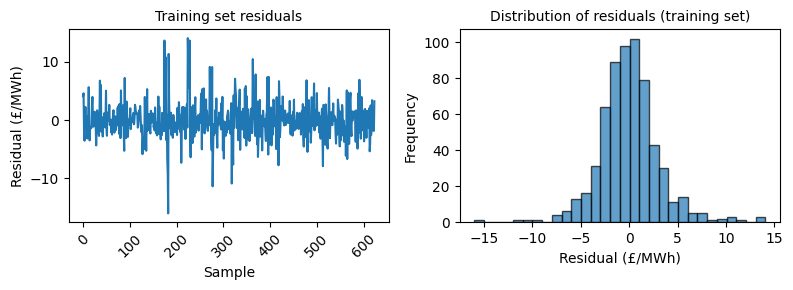

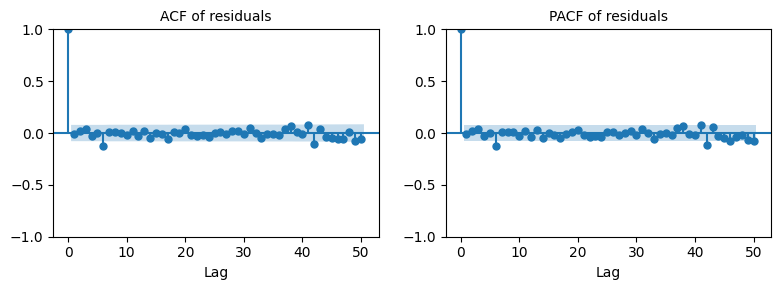

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train_resid = np.asarray(arima_result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
ax1.plot(train_resid, label="Residuals")
ax1.set_xlabel("Sample", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.set_title("Training set residuals", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(train_resid, bins=30, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Distribution of residuals (training set)", fontsize=10)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(train_resid, lags=50, ax=ax1)
ax1.set_title("ACF of residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

plot_pacf(train_resid, lags=50, ax=ax2)
ax2.set_title("PACF of residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

In [56]:
from utilities.evaluation import rmse, mae

# Hybrid forecast = GBDT prediction + ARIMA residual forecast
gbdt_pred = gbdt.predict(exog_test)
arima_pred = arima_result.forecast(steps=len(endog_test))
point_forecast = gbdt_pred + np.asarray(arima_pred)

print(f"RMSE: {rmse(point_forecast, endog_test):.2f} £/MWh")
print(f"MAE: {mae(point_forecast, endog_test):.2f} £/MWh")

RMSE: 7.34 £/MWh
MAE: 6.33 £/MWh


Plot results:

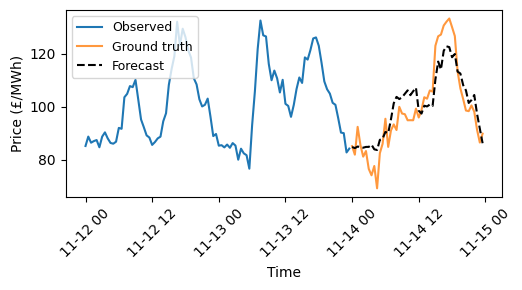

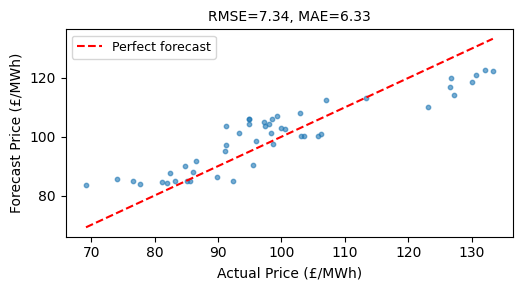

In [57]:
y_pred = np.asarray(point_forecast)
y_true = np.asarray(endog_test)
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.plot(endog_train.iloc[-(2 * len(endog_test)):], label="Observed")
ax.plot(endog_test, label="Ground truth", alpha=0.8)
ax.plot(endog_test.index, point_forecast, ls="--", color="k", label="Forecast")
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.tick_params(axis="x", labelrotation=45)
ax.legend(fontsize=9)
plt.show()


fig, ax = plt.subplots(figsize=(16 / 3, 3), layout="tight")
scatter = ax.scatter(endog_test, point_forecast, alpha=0.6, s=10)
ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--",
    label="Perfect forecast",
)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
plt.show()

Study the residuals of the forecast:

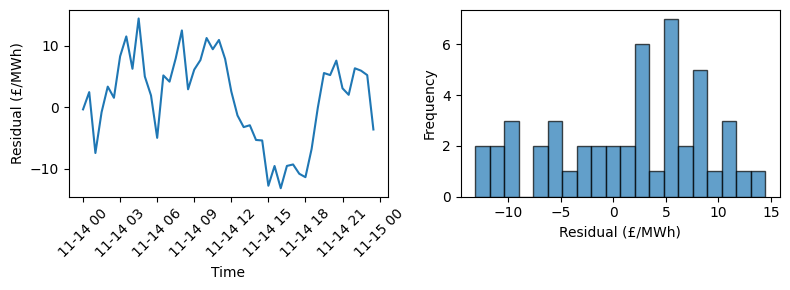

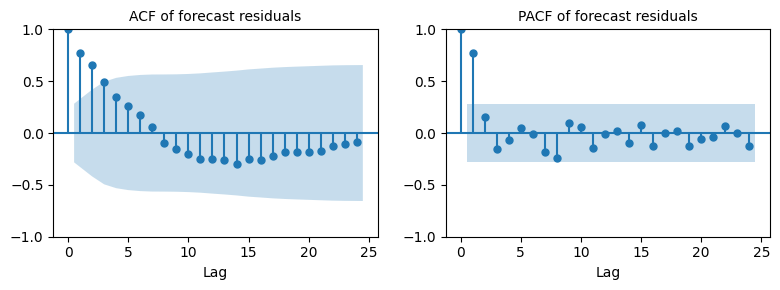

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resi = point_forecast - endog_test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")

ax1.plot(resi)
ax1.set_xlabel("Time", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(resi, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(resi, lags=24, ax=ax1)
ax1.set_title("ACF of forecast residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

plot_pacf(resi, lags=24, ax=ax2)
ax2.set_title("PACF of forecast residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

### 3.1 Bootstrapping the residuals of the point forecast

To compute confidence intervals on the forecasts, conditional sieve
bootstrapping is used on the ARIMA residuals (the unexplained variation
after both stages of the hybrid model).

Validate that sieve bootstrapping is an acceptable method:


Mean of sieve residuals: 0.000000
Standard deviation of sieve residuals: 3.07


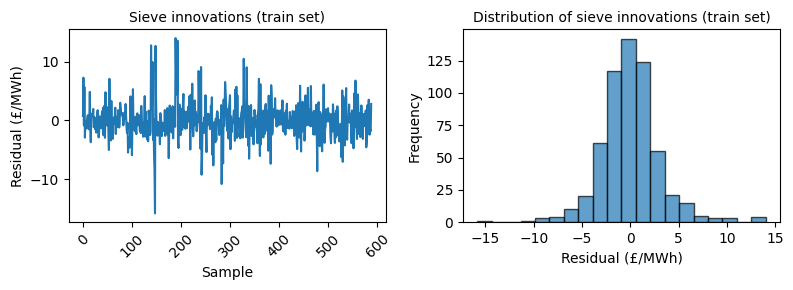

In [89]:
# Fit AR(p) sieve model to residuals
n = len(resi)
p_sieve = int(n / np.log(n) ** (1 / 4)) + 1
sieve_model = sm.tsa.AutoReg(train_resid, lags=p_sieve, old_names=False)
sieve_fitted = sieve_model.fit()

# Get innovations (epsilon_k) from sieve and center them
sieve_resid = sieve_fitted.resid
epsilon_centered = sieve_resid - sieve_resid.mean()
print(f"\nMean of sieve residuals: {sieve_resid.mean():.6f}")
print(f"Standard deviation of sieve residuals: {sieve_resid.std():.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
ax1.plot(epsilon_centered, label="Residuals")
ax1.set_xlabel("Sample", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.set_title("Sieve innovations (train set)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(epsilon_centered, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Distribution of sieve innovations (train set)", fontsize=10)
plt.show()

In [ ]:
from utilities.bootstrap import cond_sieve_bootstrap

n_bootstrap = 500

bootstrap_paths = cond_sieve_bootstrap(
    train_resid, point_forecast, n_bootstrap, seed=0
)

ci_lower = np.percentile(bootstrap_paths, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_paths, 97.5, axis=0)
ci_median = np.percentile(bootstrap_paths, 50, axis=0)
print(f"Bootstrapping completed with {n_bootstrap} samples")
print(f"Mean CI width: {np.mean(ci_upper - ci_lower):.2f} £/MWh")

Bootstrap completed with 500 samples
Mean CI width: 12.80 £/MWh


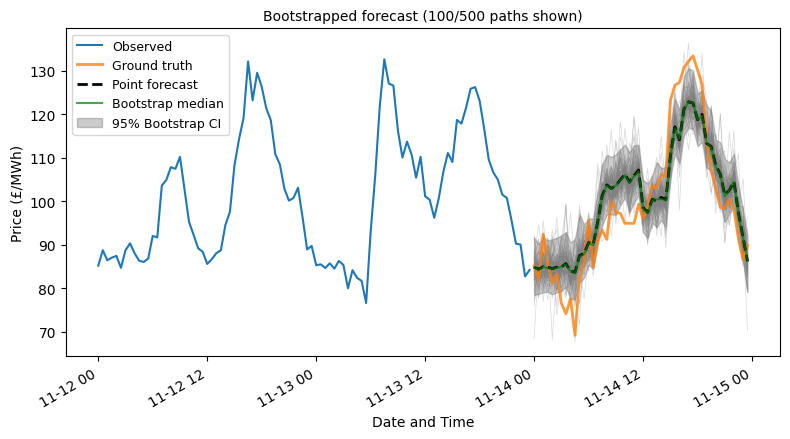

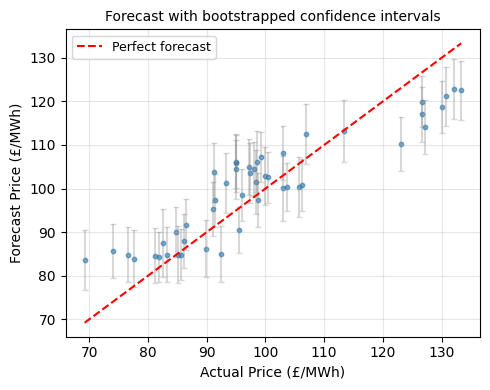

In [91]:
# Visualise bootstrap paths
fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="tight")

n_sample = 100
for b in range(n_sample):
    ax.plot(
        endog_test.index,
        bootstrap_paths[b, :],
        color="gray",
        alpha=0.3,
        linewidth=0.5,
    )

ax.plot(endog_train.iloc[-(2 * len(endog_test)):], label="Observed", color="C0")
ax.plot(endog_test, label="Ground truth", color="C1", linewidth=2, alpha=0.8)
ax.plot(endog_test.index, point_forecast, "k--", label="Point forecast", linewidth=2)

ax.plot(
    endog_test.index, ci_median,
    "g-", label="Bootstrap median", linewidth=1.5, alpha=0.7,
)
ax.fill_between(
    endog_test.index, ci_lower, ci_upper,
    color="k", alpha=0.2, label="95% Bootstrap CI",
)
ax.set_xlabel("Date and Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(
    f"Bootstrapped forecast ({n_sample}/{n_bootstrap} paths shown)",
    fontsize=10,
)
ax.legend(fontsize=9, loc="best")
plt.xticks(rotation=30, ha="right")
plt.show()

# Scatter plot with bootstrapped uncertainties
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(endog_test, point_forecast, alpha=0.6, s=10)
ci_half_width = (ci_upper - ci_lower) / 2
ax.errorbar(
    endog_test, point_forecast, yerr=ci_half_width,
    fmt="none", ecolor="gray", alpha=0.3, capsize=2,
)
ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--",
    label="Perfect forecast",
)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title("Forecast with bootstrapped confidence intervals", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

## 4. Rolling day-ahead forecast evaluation

We implement a rolling forecast where we:
1. Fit the hybrid GBDT + ARIMA model on a window of historical data
2. Forecast tomorrow's prices using NESO forecasts
3. Bootstrap the ARIMA residuals to get confidence intervals
4. Slide the window forward and repeat

In [92]:
from utilities.forecast import Forecaster

class HybridForecaster(Forecaster):
    """Day-ahead forecaster using GBDT + ARIMA hybrid."""

    def __init__(self, *, arima_order, **kwargs):
        super().__init__(**kwargs)
        self._arima_order = arima_order
        self._gbdt = None
        self._arima_result = None

    def _fit(self, endog, exog=None):
        # Stage 1: Fit GBDT
        self._gbdt = HistGradientBoostingRegressor()
        self._gbdt.fit(exog, endog)

        # Stage 2: Fit ARIMA on GBDT residuals
        gbdt_residuals = endog - self._gbdt.predict(exog)
        arima_model = sm.tsa.SARIMAX(
            endog=gbdt_residuals,
            order=self._arima_order,
        )
        self._arima_result = arima_model.fit(disp=False)

    def _forecast_steps(self, steps, exog=None):
        gbdt_pred = self._gbdt.predict(exog)
        arima_pred = self._arima_result.forecast(steps=steps)
        return gbdt_pred + np.asarray(arima_pred)

    def _get_residuals(self):
        return np.asarray(self._arima_result.resid)

In [ ]:
# Rolling forecast parameters
n_train_samples = 48 * 7 * 52 * 2  # two years of training data
forecast_days = 14
n_bootstrap = 500

print("Rolling forecast configuration:")
print(f"  Training set size: {n_train_samples} samples")
print(f"  Forecast days: {forecast_days}")
print(f"  Bootstrap samples: {n_bootstrap}")

# Create issue times (period 18 = 08:30 London time)
start_time = pd.Timestamp("2024-11-01 08:30", tz="Europe/London")
end_time = start_time + pd.Timedelta(days=forecast_days)
issue_times = pd.date_range(start_time, end_time, freq="D")

print("\nTimestamps at which forecasts are issued:")
print(f"  First: {issue_times[0]}")
print(f"  Last: {issue_times[-1]}")
print(f"  Total: {len(issue_times)} days")

print(f"\nARIMA order: {order}, {seasonal_order}")

Rolling forecast configuration:
  Training set size: 34944 samples
  Forecast days: 14
  Bootstrap samples: 500

Timestamps at which forecasts are issued:
  First: 2024-11-01 08:30:00+00:00
  Last: 2024-11-15 08:30:00+00:00
  Total: 15 days

ARIMA order: (1, 0, 1), (1, 0, 1, 48)


In [87]:
forecaster = HybridForecaster(arima_order=order)

print("Running rolling forecast...")
results = forecaster.rolling_forecast_dayahead(
    df_train,
    df_test,
    issue_times,
    n_train_samples,
    percentiles=[2.5, 97.5],
    n_bootstrap=n_bootstrap,
)

# Summary statistics
rmse_val = np.sqrt(np.mean((results["forecast"] - results["actual"]) ** 2))
in_ci = (results["actual"] >= results["p2.5"]) & (
    results["actual"] <= results["p97.5"]
)
coverage = in_ci.mean() * 100

print("\n" + "=" * 50)
print("RESULTS SUMMARY")
print("=" * 50)
print(f"Total forecasts: {len(results)} periods")
print(f"RMSE: {rmse_val:.2f} £/MWh")
print(f"95% CI Coverage: {coverage:.1f}%")
print(
    f"Mean CI width: {(results['p97.5'] - results['p2.5']).mean():.2f} £/MWh"
)

Running rolling forecast...
[1/15] Forecasting from 2024-11-01 08:30:00+00:00
  RMSE: 14.32, MAE: 12.87
[2/15] Forecasting from 2024-11-02 08:30:00+00:00
  RMSE: 13.36, MAE: 9.27
[3/15] Forecasting from 2024-11-03 08:30:00+00:00
  RMSE: 16.94, MAE: 10.50
[4/15] Forecasting from 2024-11-04 08:30:00+00:00
  RMSE: 16.90, MAE: 11.86
[5/15] Forecasting from 2024-11-05 08:30:00+00:00
  RMSE: 10.20, MAE: 7.86
[6/15] Forecasting from 2024-11-06 08:30:00+00:00
  RMSE: 16.88, MAE: 14.57
[7/15] Forecasting from 2024-11-07 08:30:00+00:00
  RMSE: 14.34, MAE: 10.77
[8/15] Forecasting from 2024-11-08 08:30:00+00:00
  RMSE: 7.36, MAE: 6.00
[9/15] Forecasting from 2024-11-09 08:30:00+00:00
  RMSE: 12.90, MAE: 9.77
[10/15] Forecasting from 2024-11-10 08:30:00+00:00
  RMSE: 14.41, MAE: 11.80
[11/15] Forecasting from 2024-11-11 08:30:00+00:00
  RMSE: 5.50, MAE: 4.59
[12/15] Forecasting from 2024-11-12 08:30:00+00:00
  RMSE: 11.32, MAE: 9.48
[13/15] Forecasting from 2024-11-13 08:30:00+00:00
  RMSE: 12.42,

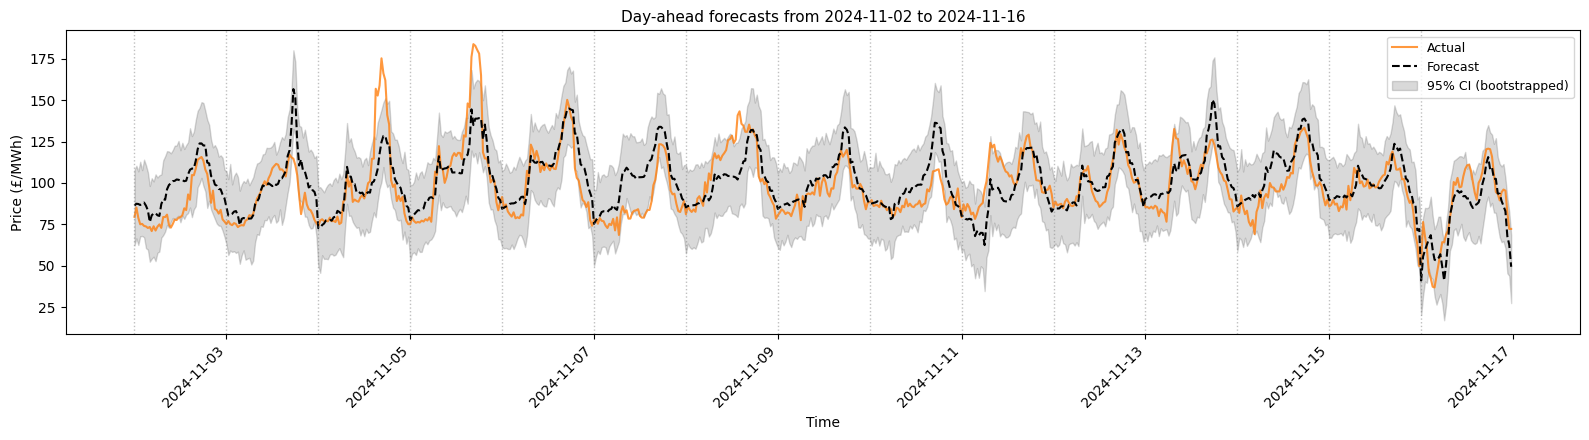

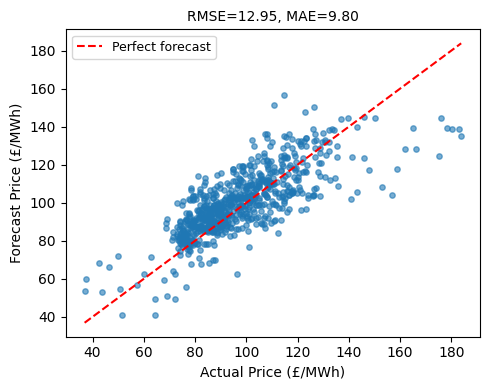

In [88]:
from utilities.evaluation import mae, rmse

ts = results.index

# Main time series plot with day boundaries
fig, ax = plt.subplots(figsize=(16, 9 / 2), layout="tight")
ax.plot(ts, results["actual"], "C1", label="Actual", linewidth=1.5, alpha=0.8)
ax.plot(ts, results["forecast"], "k--", label="Forecast", linewidth=1.5)

ax.fill_between(
    ts, results["p2.5"], results["p97.5"],
    color="k", alpha=0.15, label="95% CI (bootstrapped)",
)

unique_dates = ts.normalize().unique()
for midnight in unique_dates:
    ax.axvline(midnight, color="gray", linestyle=":", alpha=0.5, linewidth=1)

date_range = f"{unique_dates[0].date()} to {unique_dates[-1].date()}"
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(f"Day-ahead forecasts from {date_range}", fontsize=11)
ax.legend(fontsize=9, loc="best")
plt.xticks(rotation=45, ha="right")
plt.show()

# Scatter plot
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(results["actual"], results["forecast"], alpha=0.6, s=15)
ax.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--",
    label="Perfect forecast",
    linewidth=1.5,
)

y_pred = np.asarray(results["forecast"])
y_true = np.asarray(results["actual"])
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
plt.show()